# 1.31g: Centroid Motion in Lattice Coordinates

**Question:** How many lattice cells does the centroid move per timestep?

We compute the centroid's displacement in lattice coordinates (ΔC′), just like we did for individual tokens in 1.31c.

## Method

For each timestep t:

1. Compute centroid: C(t) = mean(W(t)) over all dead tokens
2. Compute ULP at centroid: U_C(t) = ULP at each component of C(t)
3. Compute lattice displacement: ΔC′(t) = [C(t+1) - C(t)] / U_C(t)
4. Compute L1 norm: |ΔC′|₁ = Σ |ΔC′ᵢ|

The L1 norm tells us the total lattice-cell distance traveled across all 64 dimensions.

**Expected phases:**
- |ΔC′|₁ >> 1: Hot phase, centroid moving many cells
- |ΔC′|₁ > 1: Cooling, moving a few cells
- |ΔC′|₁ ≈ 1: Thermal, single-cell hops
- |ΔC′|₁ = 0: Frozen, stationary

## Parameters

In [1]:
THIMBLE_PATH = "../tensors/Thimble/thimble_7.h5"
OUTPUT_PATH = "../tensors/Thimble/1.31g_delta_C_prime.safetensors"
DPI = 200

## Imports

In [2]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from safetensors.torch import save_file

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print(f"Loading data from {THIMBLE_PATH}...\n")

with h5py.File(THIMBLE_PATH, 'r') as f:
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()
    W_all = torch.from_numpy(f['W'][:]).view(torch.bfloat16)
    W_dead = W_all[:, dead_mask, :].to(torch.float32).to(device)
    
print(f"✓ Loaded W: {W_dead.shape}")

Loading data from ../tensors/Thimble/thimble_7.h5...

✓ Loaded W: torch.Size([6001, 3699, 64])


## Compute Centroid Trajectory

In [5]:
# Centroid at each timestep: C(t) = mean(W(t))
C = W_dead.mean(dim=1)  # (6001, 64)

print(f"✓ Centroid computed: {C.shape}")

✓ Centroid computed: torch.Size([6001, 64])


## Compute ULP at Centroid Positions

In [6]:
def compute_ulp(x):
    """Compute ULP for bfloat16-represented values in float32."""
    ulp_pos = torch.nextafter(x, x + torch.ones_like(x)) - x
    ulp_neg = x - torch.nextafter(x, x - torch.ones_like(x))
    ulp = torch.where(x >= 0, ulp_pos, ulp_neg)
    return ulp.abs()

# ULP at each centroid position
U_C = compute_ulp(C)  # (6001, 64)

print(f"✓ ULP computed for centroid: {U_C.shape}")

✓ ULP computed for centroid: torch.Size([6001, 64])


## Compute Centroid Displacement in Lattice Coordinates

In [7]:
# Cartesian displacement: ΔC = C(t+1) - C(t)
delta_C = C[1:] - C[:-1]  # (6000, 64)

# ULP at starting position
U_C_start = U_C[:-1]  # (6000, 64)

# Lattice displacement: ΔC′ = ΔC / U_C
delta_C_prime = delta_C / (U_C_start + 1e-30)  # (6000, 64)

print(f"✓ Lattice displacement computed: {delta_C_prime.shape}")

✓ Lattice displacement computed: torch.Size([6000, 64])


## Compute L1 Norm (Manhattan Distance in Lattice Space)

In [8]:
# L1 norm: sum of absolute values
L1_norm = delta_C_prime.abs().sum(dim=1).cpu().numpy()  # (6000,)

timesteps = np.arange(1, 6001)

print(f"✓ L1 norm computed")
print(f"  Range: [{L1_norm.min():.2e}, {L1_norm.max():.2e}]")
print(f"  Median: {np.median(L1_norm):.2f}")

✓ L1 norm computed
  Range: [0.00e+00, 1.49e+10]
  Median: 0.00


## Plot: L1 Norm Over Time

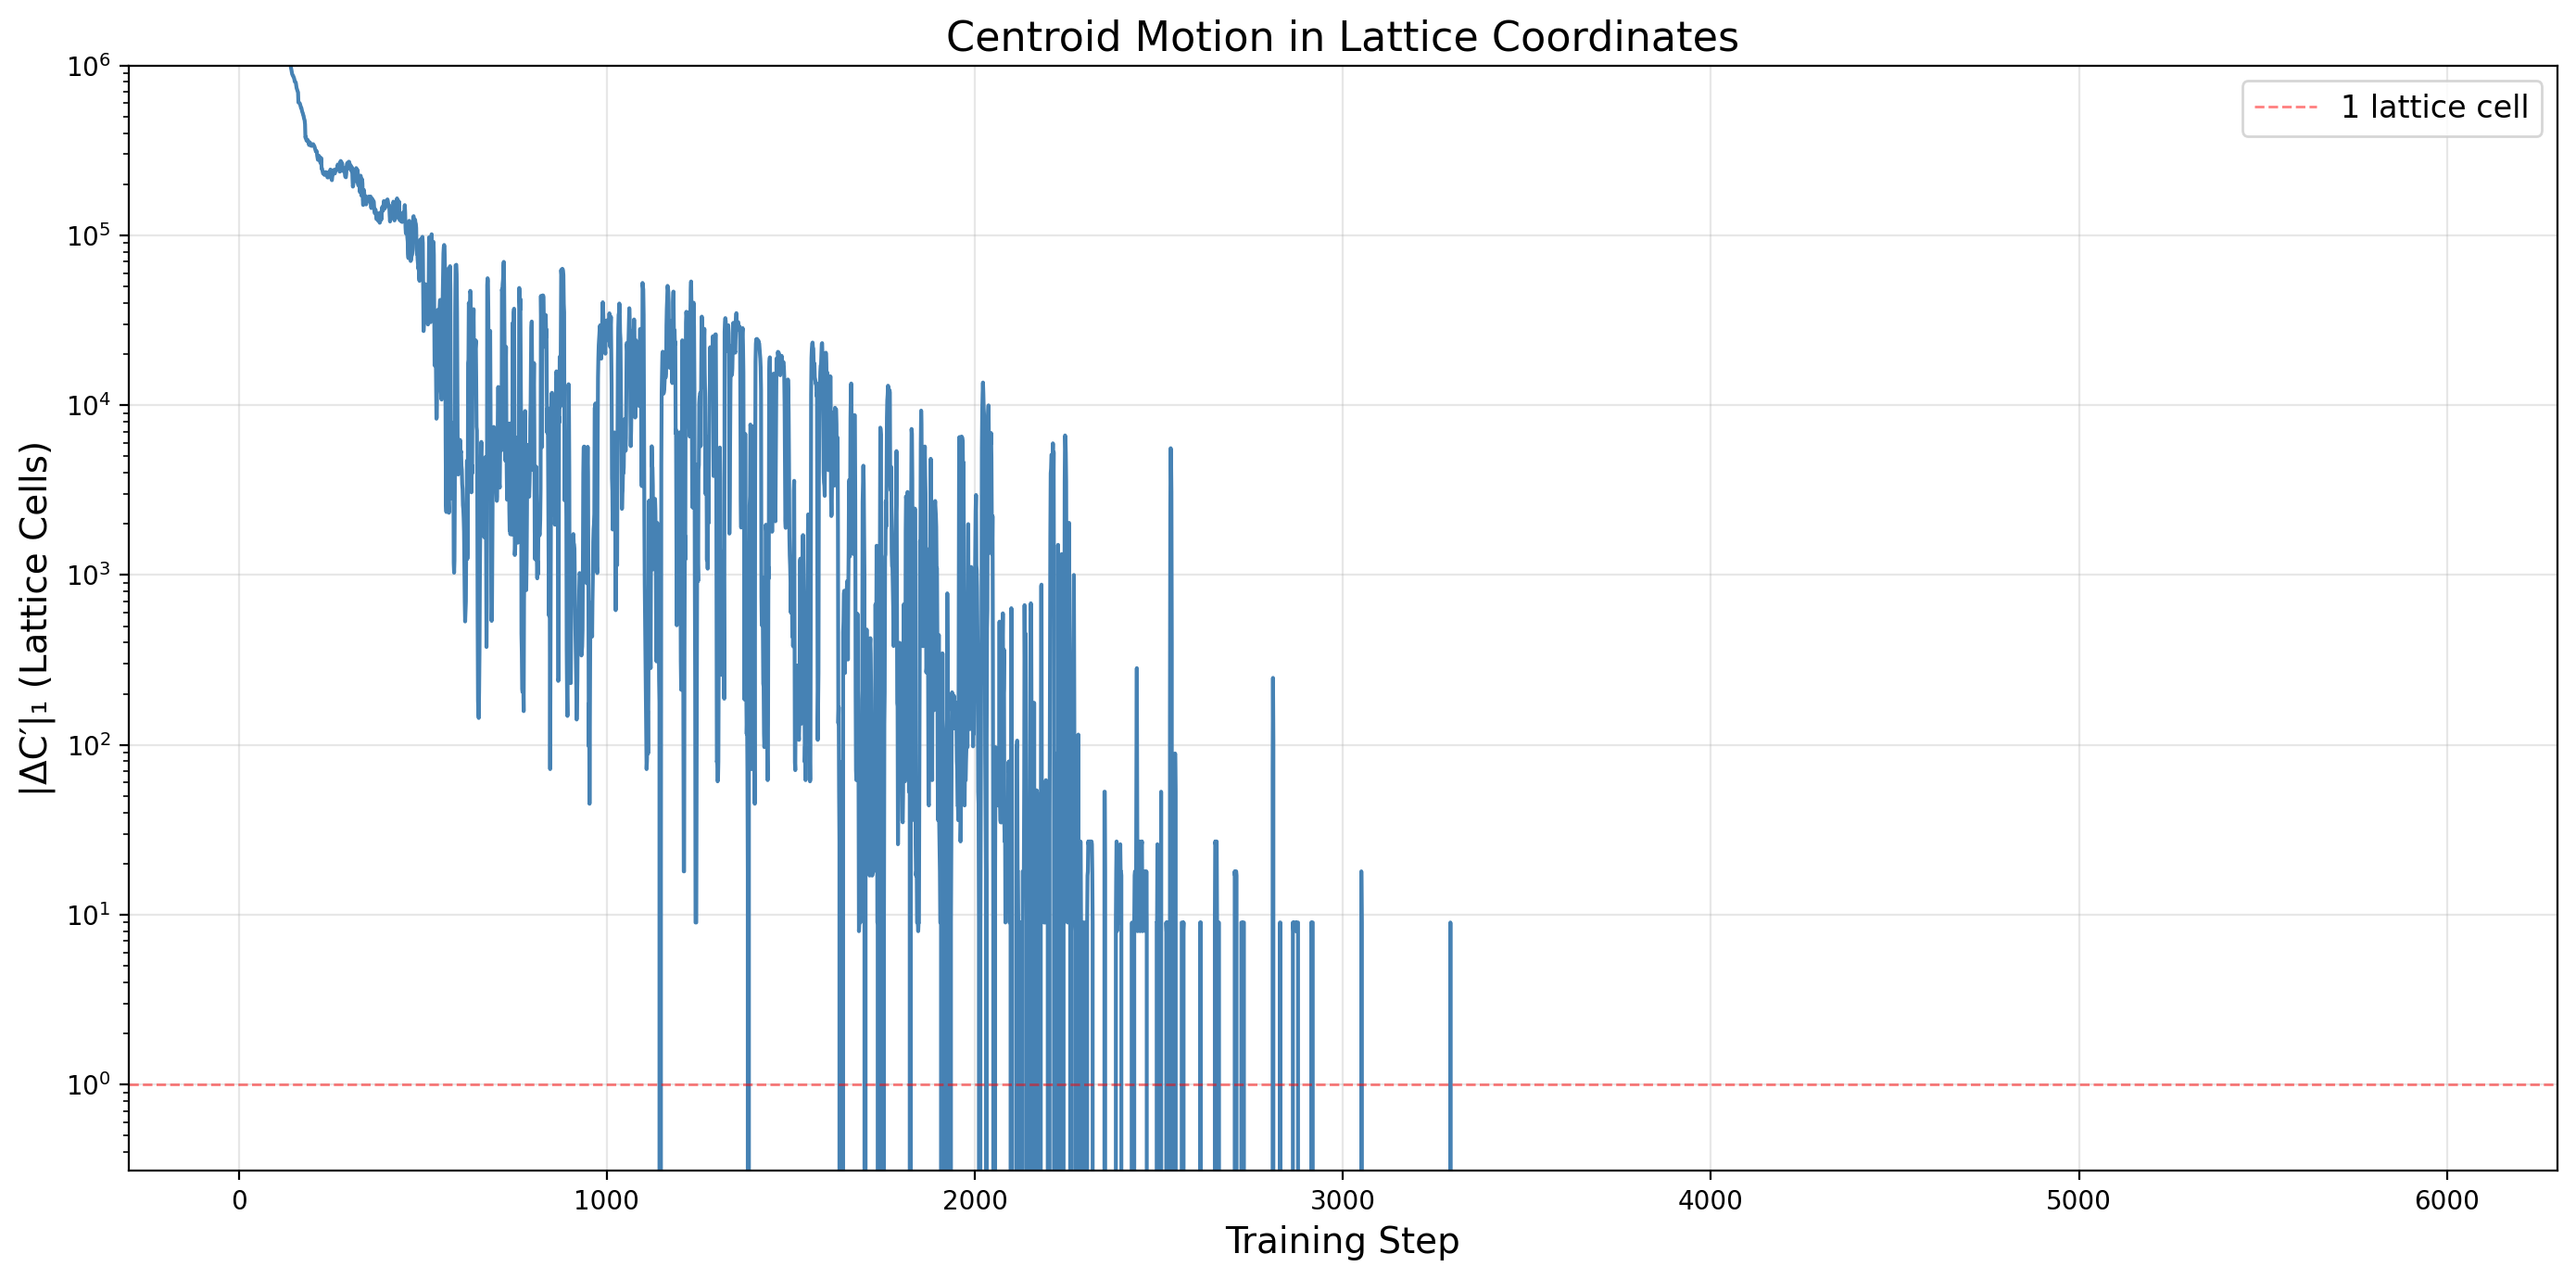

In [64]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=DPI)

ax.plot(timesteps, L1_norm, color='steelblue', linewidth=1.5)

# Reference lines
ax.axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='1 lattice cell')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('|ΔC′|₁ (Lattice Cells)', fontsize=14)
ax.set_title('Centroid Motion in Lattice Coordinates', fontsize=16)
ax.set_yscale('log')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)
ax.set_ylim(top=1e6)

plt.tight_layout()
plt.show()

## Identify Phase Transitions

In [65]:
# Count timesteps in each regime
frozen = (L1_norm == 0)
thermal = (L1_norm > 0) & (L1_norm <= 1)
cooling = (L1_norm > 1) & (L1_norm <= 10)
hot = (L1_norm > 10)

n_frozen = frozen.sum()
n_thermal = thermal.sum()
n_cooling = cooling.sum()
n_hot = hot.sum()

print("=" * 80)
print("PHASE DISTRIBUTION")
print("=" * 80)
print()
print(f"Frozen (|ΔC′|₁ = 0):     {n_frozen:5d} steps  ({n_frozen/len(L1_norm)*100:5.1f}%)")
print(f"Thermal (0 < |ΔC′|₁ ≤ 1): {n_thermal:5d} steps  ({n_thermal/len(L1_norm)*100:5.1f}%)")
print(f"Cooling (1 < |ΔC′|₁ ≤ 10): {n_cooling:5d} steps  ({n_cooling/len(L1_norm)*100:5.1f}%)")
print(f"Hot (|ΔC′|₁ > 10):        {n_hot:5d} steps  ({n_hot/len(L1_norm)*100:5.1f}%)")
print()
print("=" * 80)

PHASE DISTRIBUTION

Frozen (|ΔC′|₁ = 0):      3671 steps  ( 61.2%)
Thermal (0 < |ΔC′|₁ ≤ 1):     0 steps  (  0.0%)
Cooling (1 < |ΔC′|₁ ≤ 10):   146 steps  (  2.4%)
Hot (|ΔC′|₁ > 10):         2183 steps  ( 36.4%)



## Find Transition Points

In [66]:
# Find first timestep entering each regime
def find_first(condition):
    idx = np.where(condition)[0]
    return timesteps[idx[0]] if len(idx) > 0 else None

# Transition to thermal (first time ≤ 1)
t_thermal = find_first(L1_norm <= 1)

# Transition to frozen (first time = 0)
t_frozen = find_first(L1_norm == 0)

print("Phase transition points:")
print()
print(f"First enters thermal regime (|ΔC′|₁ ≤ 1): t = {t_thermal}")
print(f"First freeze (|ΔC′|₁ = 0):                t = {t_frozen}")
print()

if t_thermal and t_frozen:
    print(f"Time in thermal regime before freeze: {t_frozen - t_thermal} steps")

Phase transition points:

First enters thermal regime (|ΔC′|₁ ≤ 1): t = 1144
First freeze (|ΔC′|₁ = 0):                t = 1144

Time in thermal regime before freeze: 0 steps


## Summary Statistics

In [67]:
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print()

# By phase
early = L1_norm[:100]
middle = L1_norm[2500:2600]
late = L1_norm[-100:]

print(f"Median |ΔC′|₁ by phase:")
print(f"  Early (t=1-100):      {np.median(early):.2e} cells")
print(f"  Middle (t=2500-2600): {np.median(middle):.2e} cells")
print(f"  Late (t=5900-6000):   {np.median(late):.2e} cells")
print()

# Maximum displacement
max_idx = np.argmax(L1_norm)
max_val = L1_norm[max_idx]
max_step = timesteps[max_idx]

print(f"Maximum centroid motion:")
print(f"  |ΔC′|₁ = {max_val:.2e} cells at t = {max_step}")

print()
print("=" * 80)

SUMMARY STATISTICS

Median |ΔC′|₁ by phase:
  Early (t=1-100):      8.45e+06 cells
  Middle (t=2500-2600): 0.00e+00 cells
  Late (t=5900-6000):   0.00e+00 cells

Maximum centroid motion:
  |ΔC′|₁ = 1.49e+10 cells at t = 1



## Save ΔC′ for Reuse

Save the centroid lattice displacement tensor so we can use it to center the individual token displacements.

In [68]:
print(f"\nSaving ΔC′ to {OUTPUT_PATH}...\n")

# Move to CPU for saving
delta_C_prime_cpu = delta_C_prime.cpu()

save_file(
    {
        'delta_C_prime': delta_C_prime_cpu,
        'n_timesteps': torch.tensor(delta_C_prime_cpu.shape[0]),
        'hidden_dim': torch.tensor(delta_C_prime_cpu.shape[1])
    },
    OUTPUT_PATH
)

print(f"✓ Saved ΔC′")
print(f"  Shape: {delta_C_prime_cpu.shape}")
print(f"  Size: {Path(OUTPUT_PATH).stat().st_size / 1e6:.2f} MB")
print()
print("Usage in future notebooks:")
print("  from safetensors.torch import load_file")
print(f"  data = load_file('{OUTPUT_PATH}')")
print("  delta_C_prime = data['delta_C_prime'].to(device)")


Saving ΔC′ to ../tensors/Thimble/1.31g_delta_C_prime.safetensors...

✓ Saved ΔC′
  Shape: torch.Size([6000, 64])
  Size: 1.54 MB

Usage in future notebooks:
  from safetensors.torch import load_file
  data = load_file('../tensors/Thimble/1.31g_delta_C_prime.safetensors')
  delta_C_prime = data['delta_C_prime'].to(device)
